<a href="https://colab.research.google.com/github/Noorbaignuroo/Image_captioning_using_deep-_Learning_and_LSTM/blob/main/Gilgit_Baltistan_Heritage_Explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting Google Drive in Google Colab:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Accessing Data:**
Once Google Drive is mounted, you can access your uploaded folders and files from the '/content/drive/' directory.

In [ ]:
images_dir = '/content/drive/MyDrive/gb_historical_sites/Images'
captions_file = '/content/drive/MyDrive/gb_historical_sites/Captions.txt'


**Read Context Data:**

To read the image names and captions from the "context.txt" file, you can use standard Python file I/O operations.

In [ ]:

# Read data from the context.txt file
with open(captions_file, 'r') as file:
    captions_data = file.readlines()

# Process context_data to extract image names and captions
# Now you can work with the data in context_data


**Import Modules:**

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [ ]:
BASE_DIR = '/content/drive/MyDrive/gb_historical_sites/Images'
WORKING_DIR = '/gb_historical_sites/working'


**Extract Image Features:**

In [ ]:
#Load vgg16 model
model = VGG16()
#Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#Summarize
print(model.summary())


553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Extract Features from Images:
features = {}
directory = BASE_DIR

for img_name in tqdm(os.listdir(directory)):
  # Load the image from file
  img_path = os.path.join(directory, img_name)
  image = load_img(img_path, target_size=(224, 224))
  # Convert image pixels to numpy array
  image = img_to_array(image)
  # Reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  # Preprocess image for VGG
  image = preprocess_input(image)
  # Extract features
  feature = model.predict(image, verbose=0)
  # Get image ID
  img_id = img_name.split('.')[0]  # Corrected variable name
  # Store feature
  features[img_id] = feature



  0%|          | 0/180 [00:00<?, ?it/s]

In [ ]:
WORKING_DIR = '/content/drive/MyDrive/gb_historical_sites/working'  # Adjust the path if needed
os.makedirs(WORKING_DIR, exist_ok=True)  # Create the directory if it doesn't exist
WORKING_DIR = '/content/drive/MyDrive/gb_historical_sites/working'  # Adjust the path if needed
os.makedirs(WORKING_DIR, exist_ok=True)  # Create the directory if it doesn't exist


In [ ]:
import os
import pickle

# Define the working directory path
WORKING_DIR = '/content/drive/MyDrive/gb_historical_sites/working'

# Define the pickle file path
pickle_file_path = os.path.join(WORKING_DIR, 'features.pkl')

# Check if the pickle file exists before loading it
if os.path.exists(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
        features = pickle.load(f)
else:
    print("The pickle file 'feature.pkl' does not exist in the specified directory.")
# ... (your code for loading VGG16 model and processing images)

# Create a dictionary to store both image features and captions
data = {
    'features': features,  # Your extracted image features
    'captions': captions_data,  # The captions you read from the file
}

# Define the pickle file path
pickle_file_path = os.path.join(WORKING_DIR, 'features.pkl')

# Save the data dictionary to a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(data, f)

print("Image features and captions have been saved to features.pkl")
# Load image features and captions
with open(pickle_file_path, 'rb') as f:
    saved_data = pickle.load(f)

# Access image features and captions
features = saved_data['features']
captions_data = saved_data['captions']



Image features and captions have been saved to features.pkl


In [ ]:
import pickle

# Define the features dictionary (replace with your actual feature data)
features = {'image1': [0.1, 0.2, 0.3], 'image2': [0.4, 0.5, 0.6]}

# Specify the working directory and file path
WORKING_DIR = '/content/drive/MyDrive/gb_historical_sites/working'
pickle_file_path = os.path.join(WORKING_DIR, 'features.pkl')

# Save the features to a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(features, f)
import pickle

# Specify the full file path
file_path = '/content/drive/MyDrive/gb_historical_sites/working/features.pkl'

# Load the features from the pickle file
with open(file_path, 'rb') as f:
    features = pickle.load(f)




**Load the Captions Data**

In [ ]:
file_path = '/content/drive/MyDrive/gb_historical_sites/Captions.txt'

with open(file_path, 'r') as f:
    next(f)
    Captions_doc = f.read()


In [ ]:
# Create a mapping of image to captions
mapping = {}

# Process lines
for line in tqdm(Captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')

    if len(tokens) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]

    # Remove extension from Image ID
    image_id = image_id.split('.')[0]

    # Convert caption list to a string
    caption = " ".join(caption)

    # Create a list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    # Store the caption
    mapping[image_id].append(caption)



  0%|          | 0/168 [00:00<?, ?it/s]

In [ ]:
len(mapping)

168

**Preprocess the Caption Data**





In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]  # Corrected variable name to 'caption'
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Delete digits, special characters, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # Delete additional spaces
            caption = caption.replace('\s+', ' ')
            # Add start and end tags to the captions
            caption = '<start>' + " ".join([word for word in caption.split() if len(word) > 1]) + '<end>'
            captions[i] = caption


In [ ]:

generate_caption['image12.jpg']

['<start>journey through time awaits at altit fort in hunza.<end>']

In [ ]:
#preprocess the text
clean(mapping)

In [ ]:
#After preprocess od text
mapping['image12']

['<start><start>journey through time awaits at altit fort in hunza.<end><end>']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

168

In [ ]:
all_captions[:10]

["<start><start>altit fort: living testament to hunza's rich history.<end><end>",
 '<start><start>discover the past at altit fort where ancient stories come to life.<end><end>',
 "<start><start>step into history at altit fort treasure trove of hunza's heritage.<end><end>",
 '<start><start>altit fort: where stones whisper tales of bygone eras.<end><end>',
 '<start><start>explore the majesty of altit fort perched amidst stunning hunza scenery.<end><end>',
 '<start><start>altit fort: where tradition and architecture harmonize beautifully.<end><end>',
 '<start><start>unlock the secrets of altit fort cultural gem in hunza valley.<end><end>',
 '<start><start>altit fort bridge between the past and the present.<end><end>',
 "<start><start>wander through altit fort's ageless corridors and relive history.<end><end>",
 '<start><start>altit fort: where mountains meet culture in hunza.<end><end>']

In [ ]:
#Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

317

In [ ]:
#get maximum length of the caption available
max_length = max(len(caption.split())for caption in all_captions)
max_length

16

**Train Test Split**

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # Process each caption
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
        if n == batch_size:
            X1, X2, y = np.array(X1), np.array(X2), np.array(y)
            yield [X1, X2], y
            X1, X2, y = list(), list(), list()
            n = 0

**Model Creation**

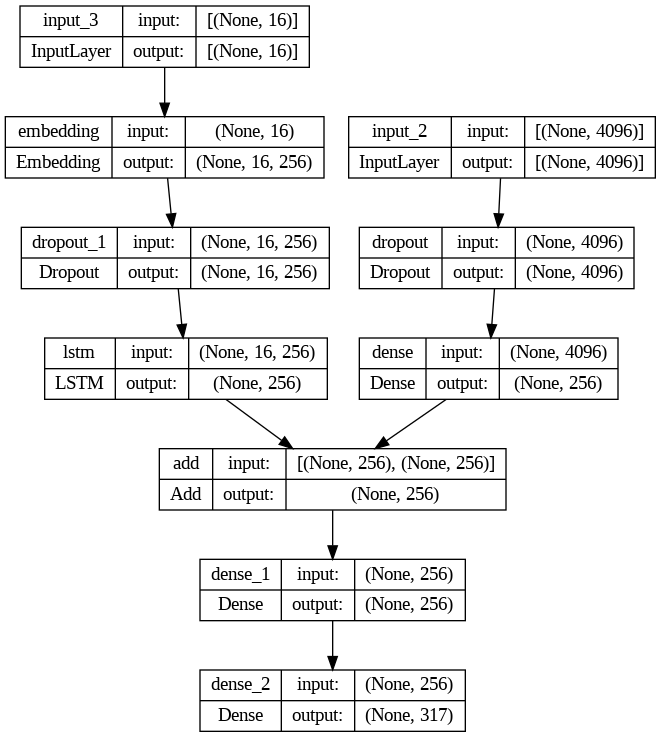

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Define your input layers
inputs1 = Input(shape=(4096,))
inputs2 = Input(shape=(max_length,))

# Image feature model
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)


In [ ]:
# Assuming train is a tuple or list containing image_filenames and captions
train_image_filenames = train[0]
train_captions = train[1]

# Print the first few image filenames to check their correctness
print("Sample image filenames:", train_image_filenames[:5])

# Set the parameters
epochs = 20
batch_size = 32
steps = max(1, len(train_image_filenames) // batch_size)  # Ensure steps_per_epoch is at least 1

for i in range(epochs):
    # create data generator
    generator = data_generator(train_image_filenames, train_captions, tokenizer, max_length, vocab_size, batch_size)

    # Print some debug information
    print(f"\nEpoch {i + 1}/{epochs}")
    print(f"Number of steps per epoch: {steps}")

    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Sample image filenames: image

Epoch 1/20
Number of steps per epoch: 1


FileNotFoundError: ignored

In [ ]:
#Save the model
model.save(WORKING_DIR + '/best_model.h5')

**Generate Captions for the Image**

In [ ]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
#Generate Caption for an Image
def predict_caption(model, image, tokenizer, max_length):
  #Add start tag for the generation process
  in_text = '<start>'
  #Iterate over the max length of the sequence
  for i in range(max_length):
    #encode input sequence
    sequence = tokrnizer.texts_to_sequences([in_text])[0]
    #Pad the sequence
    sequence = pad_sequences([sequence], max_length)[0]
    #Predict next word
    yhat = model.predict([image_sequence], verbose=0)
    #Get index with high probability
    yhat = np.argmax(yhat)
    #Convert index to word
    word = idx_to_word(yhat, tokenizer)
    #Stop if word not found
    if word is None:
      break
    #append word as input for generating next word
    in_text += " " + word
    #stop if we reach and tag
    if word as end '<end>':
      break
    return in_text






In [ ]:
#Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
  #get actual caption
  captions = mapping[key]
  #predict the caption for image
  y_pred = predict_caption(model, feautures[key], tokenizer, max_length)
  #split into words
  actual_captions = [caption,split(), for caption in captions]
  y_pred = y_pred.split()
  #
